In [2]:
# TODO: (NEXT_STAGE)

# clean up the code, check off previous todos
# write out what has been achieved
# integrate code for 3d scatterplots
# organize (and possibly attempt)

# send an email to Suzan about next stepsx/big picture
# systematize the presentation of solutions

# I NEED TO GO BACK TO THE DRAWING BOARD, TIE THINGS BACK
# DO I KNOW ABOUT HOW MANY SOLUTIONS I CAN GET?

In [3]:
"""
Questions to answer:
1.Is there more than one bull's eye?
--- PART A: are inversions consistent for the same source mechanism?

--- Plot the space first!

First bound the iterates in gradient descent algorithm
* no need if we're coming from tp space. bounding is automatic

Then do a mix of hierarchical grid search with gradient descent

Table the solutions and compare them graphically in 3D

--- PART B: can different source mechanisms be distinguished?
???
"""

"""
# TODO: Part A
1. <Pending>
    fix it only at the end, trigonometric functions are periodic
2. 
3. 


# GENERAL NOTES
Strike range: [0, 360]
Dip range: [-90, 90]
Rake range: [-180, 180]

Paula is almost done with the Uganda measurements

Beachball has two planes that cross
Every amplitude has 

Design gradient descent for orientation instead of sdr
Use longitude and colatitude, each of which is an angle
See if there are direct conversions between the two
-- potential for duplicates, but I should write out the fxns first

slip is red/white into black and positive upwards, range is [-180, 180]

LUCAS' PAPER
Constraining uncertainties
Takeoff angle and azimuth affect the epicentral uncertainty
Error ellipse vs uncertainties in angles...
Systematic vs adversarial errors


# Colors in matplotlib
# viridis, plasma, inferno, magma, cividis
# Greys, Blues, Purples, Greens, Oranges, Reds
# YlOrBr, YlOrRd, OrRd, PuRd, RdPu, BuPu
# GnBu, PuBu, YlGnBu, PuBuGn, BuGn, YlGn


"""

"\n# TODO: Part A\n1. <Pending>\n    fix it only at the end, trigonometric functions are periodic\n2. \n3. \n\n\n# GENERAL NOTES\nStrike range: [0, 360]\nDip range: [-90, 90]\nRake range: [-180, 180]\n\nPaula is almost done with the Uganda measurements\n\nBeachball has two planes that cross\nEvery amplitude has \n\nDesign gradient descent for orientation instead of sdr\nUse longitude and colatitude, each of which is an angle\nSee if there are direct conversions between the two\n-- potential for duplicates, but I should write out the fxns first\n\nslip is red/white into black and positive upwards, range is [-180, 180]\n\nLUCAS' PAPER\nConstraining uncertainties\nTakeoff angle and azimuth affect the epicentral uncertainty\nError ellipse vs uncertainties in angles...\nSystematic vs adversarial errors\n\n\n# Colors in matplotlib\n# viridis, plasma, inferno, magma, cividis\n# Greys, Blues, Purples, Greens, Oranges, Reds\n# YlOrBr, YlOrRd, OrRd, PuRd, RdPu, BuPu\n# GnBu, PuBu, YlGnBu, PuBuGn

**Libraries & Global Variables**

In [4]:
from numpy import *
import matplotlib.pyplot as plt
import seismic_model as sm
import minimize_objective as mo
from obspy.taup import TauPyModel
import functions as fx
import importlib
import sklearn.mixture as mix

eps = 1e-10; halfpi = pi/2; twopi = 2*pi
i_hat = array([1,0,0]); j_hat = array([0,1,0]); k_hat = array([0,0,1])
random.seed(2024)

***
### A. Hybrid search
***

**Coarse Grid**

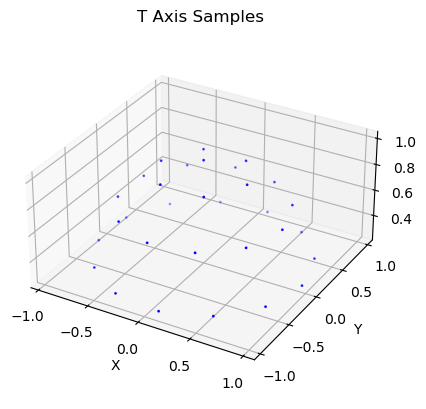

In [5]:
# construct rigid hemisphere samples to set up source grid

step_size = 25 # in degrees, max 90
Ts = fx.rigid_hemisphere_samples(step_size, angles=False)
Ts = array(Ts)

fig1 = plt.figure()
ax = plt.axes(projection='3d')
ax.set_box_aspect((1,1,.5))
ax.scatter3D([T[0] for T in Ts],
                [T[1] for T in Ts],
                [T[2] for T in Ts], c='b', s=1)
ax.set_title("T Axis Samples")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

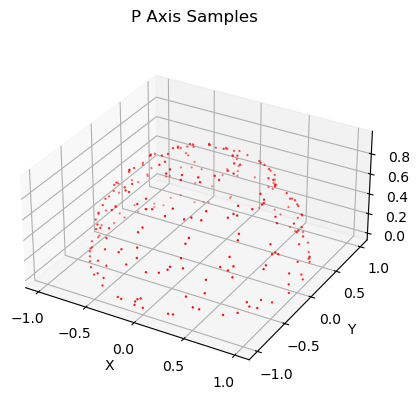

In [6]:
# plot p-axis samples
Ps = []
normal = k_hat # upper hemisphere
normal = normal/linalg.norm(normal)
for T in Ts:
    P_start = fx.starting_direc(T, normal)
    for theta in range(0, 180, step_size):
        P = fx.rotate_vector(P_start, T, deg2rad(theta))
        Ps.append(P)
Ps = array(Ps)

# red color
fig2 = plt.figure()
ax = plt.axes(projection='3d')
ax.set_box_aspect((1,1,.5))
ax.scatter3D([P[0] for P in Ps],
                [P[1] for P in Ps],
                [P[2] for P in Ps], c='r', s=1/2)
ax.set_title("P Axis Samples")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

Observations:

* Uniform spread of one axis does not map to the other - implications?
* Resulting beachballs may be biased towards a certain category (see sdr scatterplots)

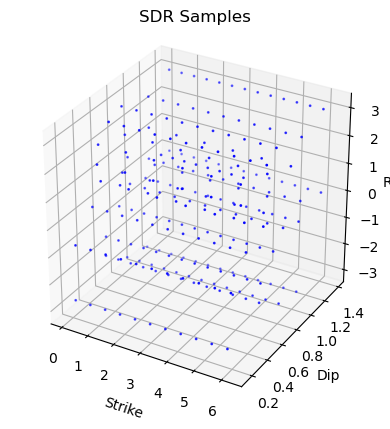

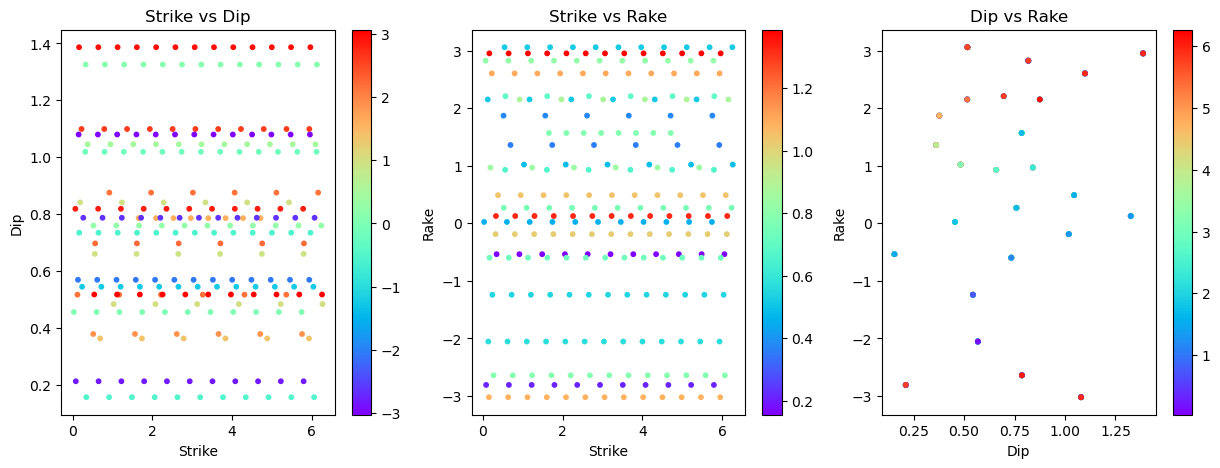

In [7]:
ratio = int(len(Ps)/len(Ts))
sdrs = []
sdrs_alt = []
for i in range(len(Ts)):
    t = Ts[i]
    for j in range(ratio):
        p = Ps[i*ratio + j]
        sdr, sdr_alt = fx.tp2sdr(t, p)
        sdrs.append(sdr)
        sdrs_alt.append(sdr_alt)
sdrs = array(sdrs)
sdrs_alt = array(sdrs_alt)

# 3d plot of sdrs/sdrs_alt
fig3 = plt.figure()
ax = plt.axes(projection='3d')
ax.set_box_aspect((1,1,1))
ax.scatter3D(sdrs[:,0], sdrs[:,1], sdrs[:,2], c='b', s=1)
ax.set_title("SDR Samples")
ax.set_xlabel('Strike')
ax.set_ylabel('Dip')
ax.set_zlabel('Rake')
plt.show()

# 2D scatterplots for sd/sr/dr
fig4 = plt.figure(figsize=(15,5))
ax1 = fig4.add_subplot(131)
plt1 = ax1.scatter(sdrs[:,0], sdrs[:,1], c=sdrs[:,2], s=10, cmap='rainbow')
ax1.set_title("Strike vs Dip")
ax1.set_xlabel('Strike')
ax1.set_ylabel('Dip')
cbar1 = fig4.colorbar(plt1)
ax2 = fig4.add_subplot(132)
plt2 = ax2.scatter(sdrs[:,0], sdrs[:,2], c=sdrs[:,1], s=10, cmap='rainbow')
ax2.set_title("Strike vs Rake")
ax2.set_xlabel('Strike')
ax2.set_ylabel('Rake')
cbar2 = fig4.colorbar(plt2)
ax3 = fig4.add_subplot(133)
plt3 = ax3.scatter(sdrs[:,1], sdrs[:,2], c=sdrs[:,0], s=10, cmap='rainbow')
ax3.set_title("Dip vs Rake")
ax3.set_xlabel('Dip')
ax3.set_ylabel('Rake')
cbar3 = fig4.colorbar(plt3)
plt.show()

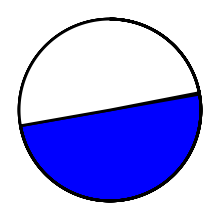

In [8]:
# visualization: we're looking at the bottom half

beachball = fx.beachball([0,0,10])

**Source Mechanism**

Original sdr: [ 141.05743276   64.77466961 -112.7692599 ]


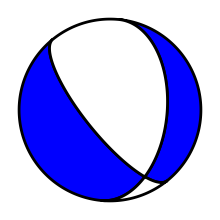

In [9]:
# use seed to produce source mechanisms
seed = 123
random.seed(seed)

# create random array for t, normalised to 1
t = random.rand(3)
t /= linalg.norm(t)

# create random array for p, normalised to 1
normal = random.rand(3)
normal /= linalg.norm(normal)
p = fx.starting_direc(t, normal)

# get sdr for test case
sdr_orig, sdr_orig_alt = fx.tp2sdr(t, p, deg=True)
print(f'Original sdr: {sdr_orig}')

# plot corresponding beachball
beachball = fx.beachball(sdr_orig)

# set up parameters for inversion
model = TauPyModel(model='ak135')  # velocity model

'''
THESE SHOULD BE CHANGED LATER
'''
hdepth = 15  # km - assumed quake depth << to get takepff angles
epdist = 10  # degrees - epicentral distance
azimuth = 200  # degrees - azimuth of seismometer


arrivals = model.get_travel_times(source_depth_in_km=hdepth,
                        distance_in_degree=epdist, phase_list=['P', 'S'])
takeoff_angles = [a.takeoff_angle for a in arrivals]
alpha, beta = 5.8000, 3.4600
b3_over_a3 = (beta/alpha)**3

# generate observed amplitude vector
Ao = array(fx.Rpattern(sdr_orig, azimuth, takeoff_angles, [alpha, beta]))

**Model Space**

1. From sdr samples

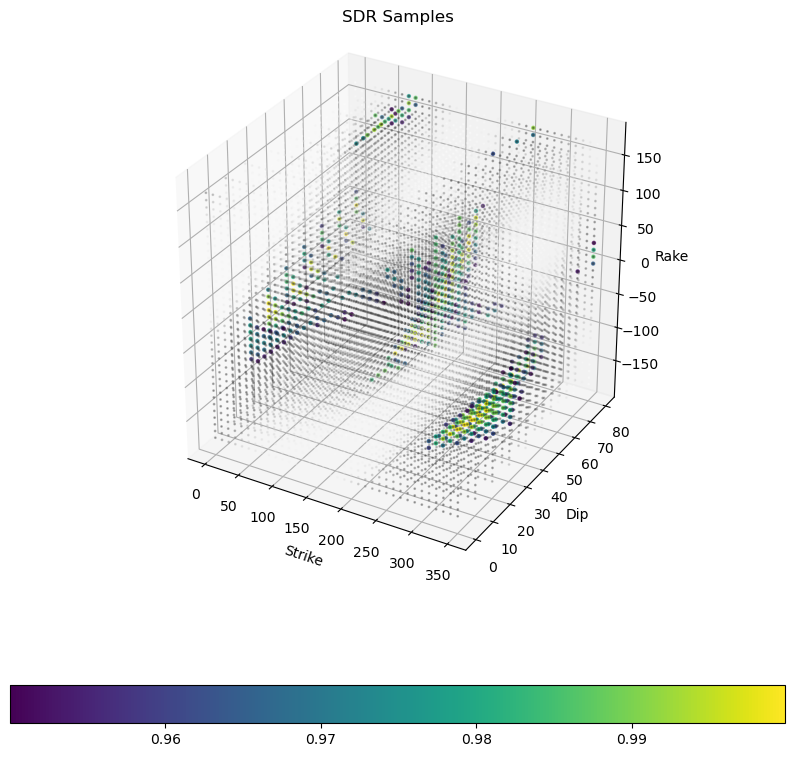

In [10]:

# Generate sdr grid, evenly spaced in each dimension
# For each scr, calculate the amplitude vector
# Record the cossim between Ao and the amplitude vector
# Store cossims in a 3D array
# Plot the 3D array and color by cossim

threshold = 0.95

# Generate sdr grid
step_size = 10  # in degrees
s_range = arange(0, 360, step_size)
d_range = arange(0, 90, step_size)
r_range = arange(-180, 180, step_size)

sdr_grid = zeros((len(s_range), len(d_range), len(r_range), 3))
high_amplitudes = []
high_unit_amplitudes = []
amplitudes = zeros((len(s_range), len(d_range), len(r_range), 3))
unit_amplitudes = zeros((len(s_range), len(d_range), len(r_range), 3))
cossims = zeros((len(s_range), len(d_range), len(r_range)))
# sdr_grid.shape

for i in range(len(s_range)):
    for j in range(len(d_range)):
        for k in range(len(r_range)):
            sdr = array([s_range[i], d_range[j], r_range[k]])
            sdr_grid[i, j, k] = sdr
            amplitude = fx.Rpattern(sdr, azimuth, takeoff_angles, [alpha, beta])
            amplitudes[i, j, k] = amplitude
            unit_amplitudes[i, j, k] = amplitude/linalg.norm(amplitude)
            cossims[i, j, k] = fx.cossim(Ao, amplitude)
            if cossims[i, j, k] > threshold:
                high_amplitudes.append(amplitude)
                high_unit_amplitudes.append(amplitude/linalg.norm(amplitude))


# plot the cossim grid on sdr scatterplot
fig5 = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.set_box_aspect((1,1,1))

strikes = sdr_grid[:,:,:,0].flatten()
dips = sdr_grid[:,:,:,1].flatten()
rakes = sdr_grid[:,:,:,2].flatten()
cossims = cossims.flatten()
assert len(strikes) == len(cossims)
# get where cossims > threshold
indices = where(cossims > threshold)
# print(sum(cossims > threshold), len(cossims))
# print(indices)
# print(len(strikes))
# print(sdr_grid.flatten().shape)
# print(strikes[10000])

# get tp values for high cossims
tps = []
sdr_pairs = []
# print(indices[0])
for index in indices[0]:
    # print(index)
    sdr = [strikes[index], dips[index], rakes[index]]
    # print(sdr)
    tp = fx.sdr2tp(sdr, deg=True)
    # print(tp)
    sdrs = fx.tp2sdr(tp[0], tp[1], deg=True)
    tps.append(tp)
    sdr_pairs.append(sdrs)

high_strikes = strikes[indices]
high_dips = dips[indices]
high_rakes = rakes[indices]
high_cossims = cossims[indices]

ax.scatter3D(strikes, dips, rakes, c=cossims, cmap='Greys', s=1, alpha=0.3)
scatter = ax.scatter3D(high_strikes, high_dips, high_rakes,
                       c=high_cossims, cmap='viridis', s=5)
cbar = fig5.colorbar(scatter, ax=ax, orientation='horizontal')
ax.set_title("SDR Samples")
ax.set_xlabel('Strike')
ax.set_ylabel('Dip')
ax.set_zlabel('Rake')
plt.show()

# fix dip range
# make slices (see later todo)
# connect with lines in tp/sdr space

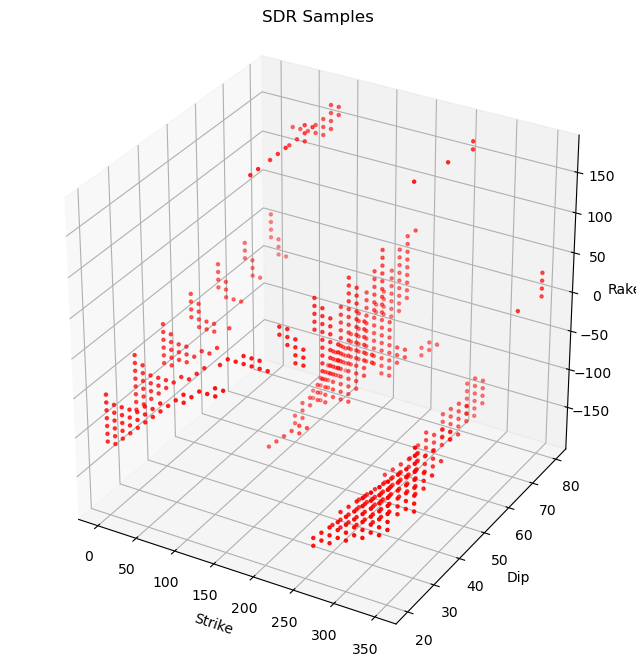

In [11]:
# just the reds now

fig6 = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')
ax.set_box_aspect((1,1,1))
scatter = ax.scatter3D(high_strikes, high_dips, high_rakes, c='r', s=5)
ax.set_title("SDR Samples")
ax.set_xlabel('Strike')
ax.set_ylabel('Dip')
ax.set_zlabel('Rake')
plt.show()


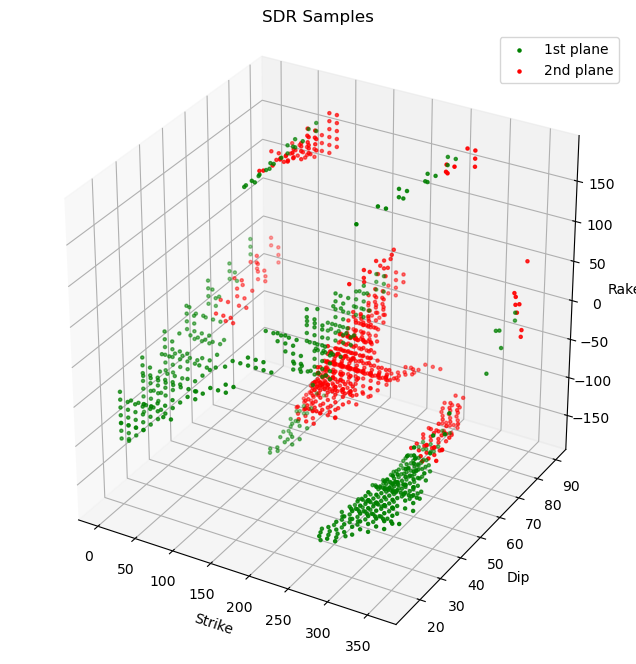

In [12]:
# scatter sdr_pairs[0] in green and sdr_pairs[1] in red

# print(len(sdr_pairs)*2)

fig7 = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')
ax.set_box_aspect((1,1,1))

ax.scatter3D([pair[0][0] for pair in sdr_pairs],
             [pair[0][1] for pair in sdr_pairs],
             [pair[0][2] for pair in sdr_pairs],
             c='g', s=5, label='1st plane')

ax.scatter3D([pair[1][0] for pair in sdr_pairs],
                [pair[1][1] for pair in sdr_pairs],
                [pair[1][2] for pair in sdr_pairs],
                c='r', s=5, label='2nd plane')

ax.set_title("SDR Samples")
ax.set_xlabel('Strike')
ax.set_ylabel('Dip')
ax.set_zlabel('Rake')
ax.legend()
plt.show()

609


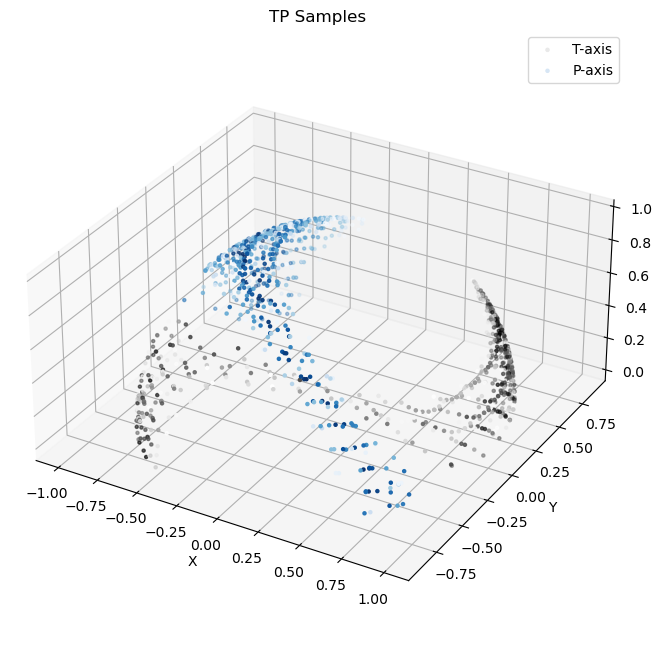

In [13]:
# plot tp[0] in green and tp[1] in red
# include a legend
print(len(tps))
test_tps = tps[:]

fig8 = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')
ax.set_box_aspect((1,1,.5))

ax.scatter3D([tp[0][0] for tp in test_tps],
                [tp[0][1] for tp in test_tps],
                [tp[0][2] for tp in test_tps],
                c=high_cossims, cmap='Greys', s=5, label='T-axis')

ax.scatter3D([tp[1][0] for tp in test_tps],
                [tp[1][1] for tp in test_tps],
                [tp[1][2] for tp in test_tps],
                c=high_cossims, cmap='Blues', s=5, label='P-axis')

ax.set_title("TP Samples")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.show()

Ao norm: 0.014312381080381756


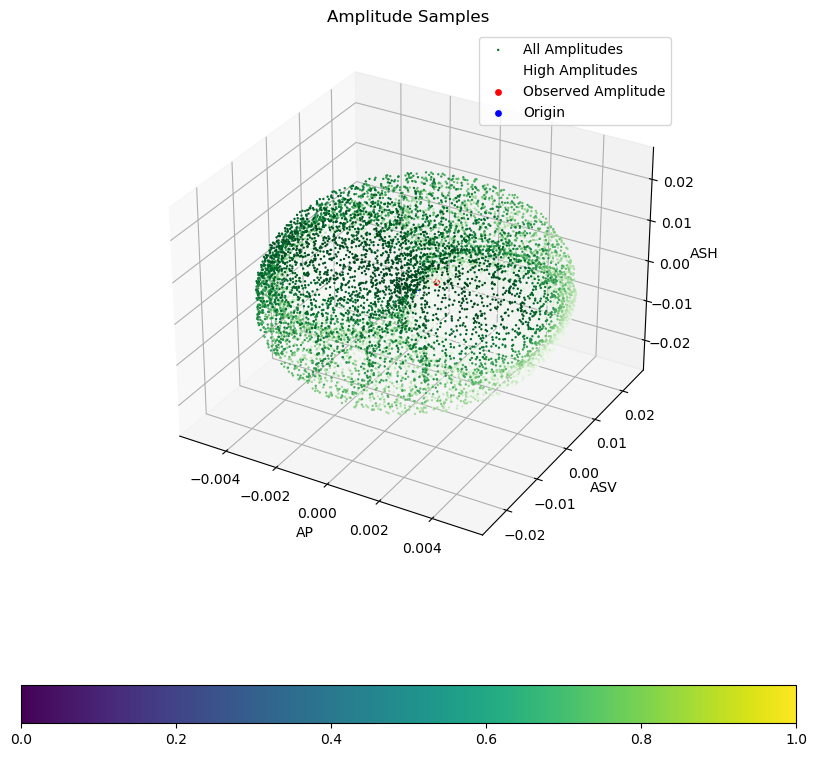

In [14]:
# 3D plot amplitudes

# use amplitudes or unit_amplitudes
cossim_amplitudes = high_amplitudes
Ao_expt = Ao
expt = amplitudes.reshape(-1, 3)
print('Ao norm:', linalg.norm(Ao_expt))

# plot all amplitudes
fig9 = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
# ax.set_box_aspect((1,1,1))
ax.scatter3D([a[0] for a in expt],
                [a[1] for a in expt],
                [a[2] for a in expt],
                c=cossims, cmap='Greens', s=.5, alpha=1, label='All Amplitudes')

ax.scatter3D([a[0] for a in cossim_amplitudes],
                [a[1] for a in cossim_amplitudes],
                [a[2] for a in cossim_amplitudes], c='r', s=1, alpha=0, label='High Amplitudes')

# add Ao to the plot
ax.scatter3D(Ao_expt[0], Ao_expt[1], Ao_expt[2], c='r', s=15, label='Observed Amplitude')
ax.scatter3D(0, 0, 0, c='b', s=15, label='Origin')

ax.set_title("Amplitude Samples")
ax.set_xlabel('AP')
ax.set_ylabel('ASV')
ax.set_zlabel('ASH')
cbar = fig9.colorbar(scatter, ax=ax, orientation='horizontal')

ax.legend()

plt.show()


In [ ]:
# CHANGE THE COLOR PROGRESSION FOR just strike, just dip or just rake
# LOOK FOR THE MANIF

Ao norm: 0.9999999999999999


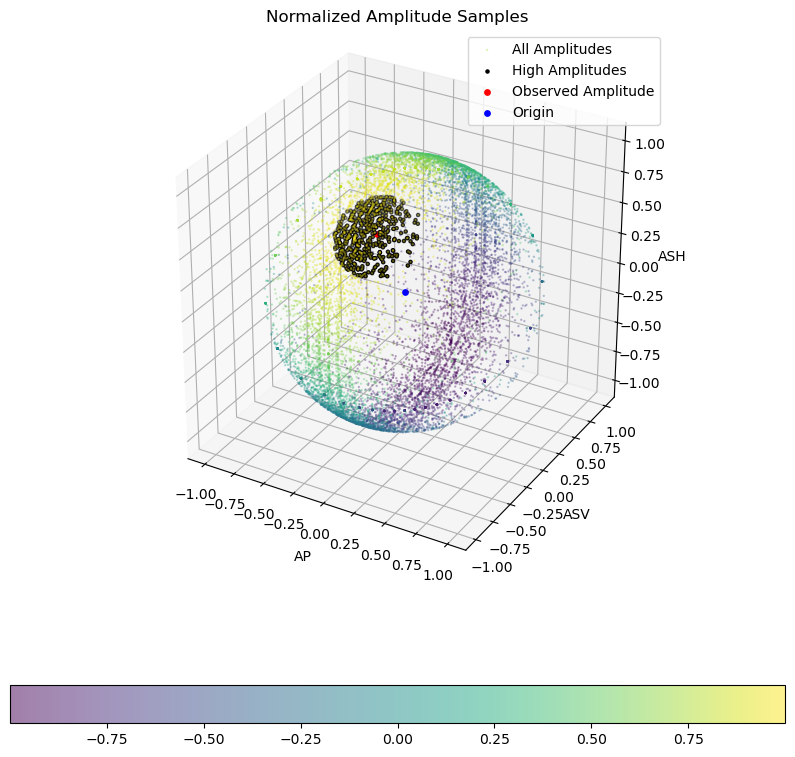

In [665]:
# 3D plot amplitudes

# use amplitudes or unit_amplitudes
cossim_amplitudes = high_unit_amplitudes
Ao_expt = Ao/linalg.norm(Ao)
expt = unit_amplitudes.reshape(-1, 3)
print('Ao norm:', linalg.norm(Ao_expt))

# plot all amplitudes
fig10 = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.set_box_aspect((1,1,1))
ax.scatter3D([a[0] for a in expt],
                [a[1] for a in expt],
                [a[2] for a in expt],
                c=cossims, cmap='viridis', s=.5, alpha=.3, label='All Amplitudes')

ax.scatter3D([a[0] for a in cossim_amplitudes],
                [a[1] for a in cossim_amplitudes],
                [a[2] for a in cossim_amplitudes], c='k', s=5, label='High Amplitudes')

# add Ao to the plot
ax.scatter3D(Ao_expt[0], Ao_expt[1], Ao_expt[2], c='r', s=15, label='Observed Amplitude')
ax.scatter3D(0, 0, 0, c='b', s=15, label='Origin')

ax.set_title("Normalized Amplitude Samples")
ax.set_xlabel('AP')
ax.set_ylabel('ASV')
ax.set_zlabel('ASH')
cbar = fig10.colorbar(scatter, ax=ax, orientation='horizontal')

ax.legend()

plt.show()


In [589]:
# I need a way to identify solution space
# Use a scree plot to determine the number of clusters
# What if I came from tp space? I may actually need to do this

# TODO: Visualize amplitude distribution coming from tp space
# see previous code ^^ see if the "squeeze" is because of source distribution


# TODO


# <LOOK AT IMPLEMENTATIONS/INTERPRETATIONS 308>
# <DESIGN A FUNCTION THAT FINDS OPTIMAL NUMBER OF CLUSTERS>
# <POTENTIALLY MOVE IN EVENS GIVEN SYMMETRY>

In [590]:
# start with 1 dip
dips = arange(5, 90, 10)
step_size = 5

# make a meshgrid for strike and rake
s_range = arange(0, 360, step_size)
r_range = arange(-180, 180, step_size)
s, r = meshgrid(s_range, r_range)

cossim_grid = zeros((len(dips), len(s_range), len(r_range)))
for i in range(len(dips)):
    for j in range(len(s_range)):
        for k in range(len(r_range)):
            sdr = array([s_range[j], dips[i], r_range[k]])
            amplitude = fx.Rpattern(sdr, azimuth, takeoff_angles, [alpha, beta])
            cossim_grid[i, j, k] = fx.cossim(Ao, amplitude)
            
# surface plots
# overlapping surface plot for regions where cossim > threshold
fig11 = plt.figure(figsize=(15,15))
for i in range(len(dips)):
    ax = fig8.add_subplot(3, 3, i+1, projection='3d')
    ax.set_box_aspect((1,1,1))
    ax.plot_surface(s, r, cossim_grid[i], cmap='Greys')
    ax.set_title(f"Dip = {dips[i]}")
    ax.set_xlabel('Strike')
    ax.set_ylabel('Rake')
    ax.set_zlabel('Cossim')
plt.show()

<Figure size 1500x1500 with 0 Axes>

In [591]:
# TODO (suggestions): now!!!

# Plot progressive surfaces in steps of strike
# Plot progressive surfaces in steps of rake

In [592]:
# TODO March 19, 2024

# Amplitude space visuals - DONE
# Surfaces formed, how many layers intersect? - ^^
# i.e. causes of different structures - Think about source function

# See where in the spaces the MO solution fits
# Best fitting + uncertainties
# Composite beachball without fills
# Color coded scatterplots for amp -> tp space

# Work towards solution plus justifiable uncertainties
# -> gotten somewhere with the conceptual structure of the problem
# empirical tests

# GOAL: understand the structure
# Try to bound the nonlinear transformation

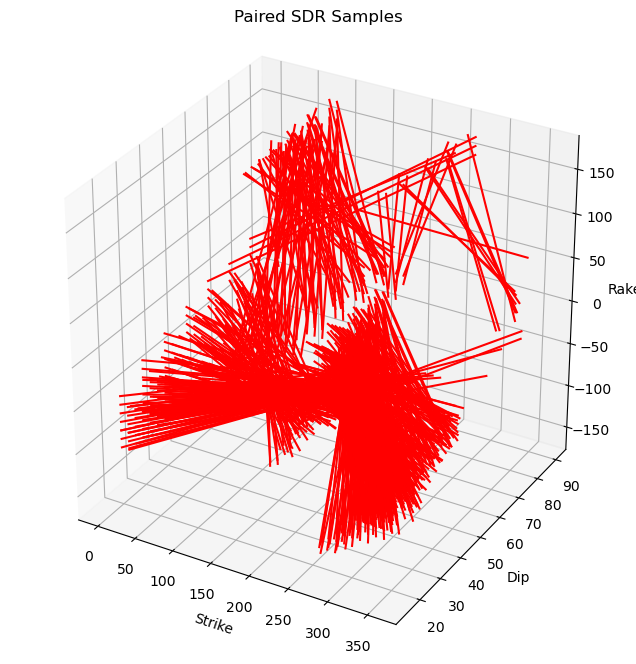

In [593]:
# plot sdr_pairs as lines from sdr_pairs[0] to sdr_pairs[1]
fig12 = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.set_box_aspect((1,1,1))
for pair in sdr_pairs:
    ax.plot3D([pair[0][0], pair[1][0]],
              [pair[0][1], pair[1][1]],
              [pair[0][2], pair[1][2]], c='r')
ax.set_title("Paired SDR Samples")
ax.set_xlabel('Strike')
ax.set_ylabel('Dip')
ax.set_zlabel('Rake')
plt.show()

2. From tp samples

In [602]:
# construct rigid hemisphere samples to set up source grid

step_size = 8 # in degrees, max 90
Ts = fx.rigid_hemisphere_samples(step_size, angles=False)
Ts = array(Ts)
Ps = []
normal = k_hat # upper hemisphere
normal = normal/linalg.norm(normal)
for T in Ts:
    P_start = fx.starting_direc(T, normal)
    for theta in range(0, 180, step_size):
        P = fx.rotate_vector(P_start, T, deg2rad(theta))
        Ps.append(P)
Ps = array(Ps)

In [603]:
# get sdr samples

ratio = int(len(Ps)/len(Ts))
sdrs = []
sdrs_alt = []
for i in range(len(Ps)):
    p = Ps[i]
    t = Ts[i//ratio]
    sdr, sdr_alt = fx.tp2sdr(t, p, deg=True)
    sdrs.append(sdr)
    sdrs_alt.append(sdr_alt)
    
sdrs = array(sdrs)
sdrs_alt = array(sdrs_alt)

In [604]:
sdrs

array([[270.        ,  45.        ,  90.        ],
       [262.        ,  45.        ,  90.        ],
       [254.        ,  45.        ,  90.        ],
       ...,
       [ 51.76210623,  74.55132203, -13.01197716],
       [ 52.7750771 ,  80.11891491,  -7.12816556],
       [ 53.19927502,  85.7577902 ,  -1.41450079]])

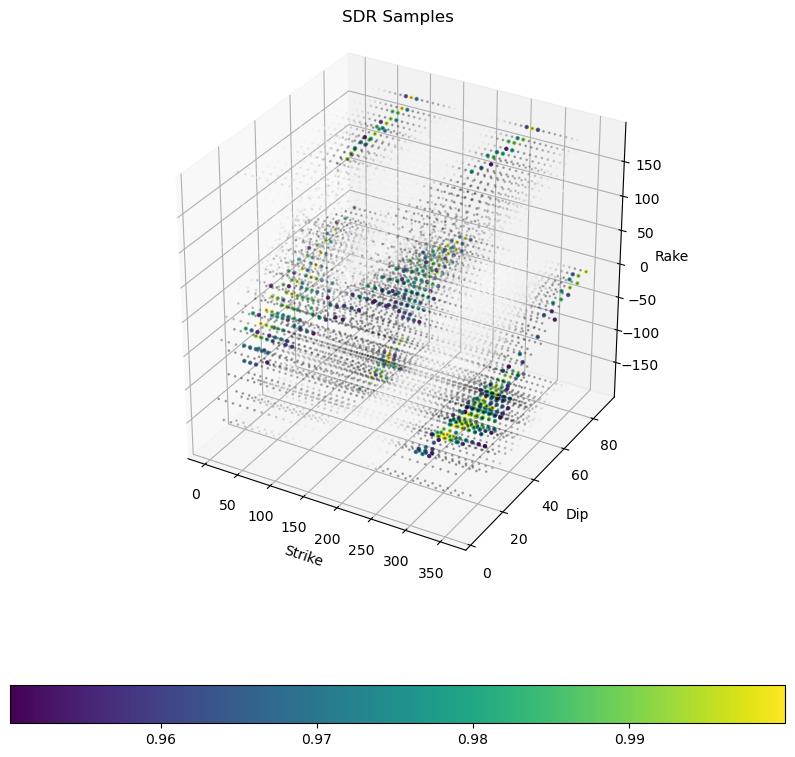

In [635]:
# loop to get high amplitudes etc
# BUG: check unit compalibility

threshold = 0.95

high_amplitudes = []
high_unit_amplitudes = []
amplitudes = zeros((len(sdrs), 3))
unit_amplitudes = zeros((len(sdrs), 3))
cossims = zeros(len(sdrs))

for i in range(len(sdrs)):
    sdr = sdrs[i]
    # BUG: check unit compatibility
    amplitude = fx.Rpattern(sdr, azimuth, takeoff_angles, [alpha, beta])
    amplitudes[i] = amplitude
    unit_amplitudes[i] = amplitude/linalg.norm(amplitude)
    cossims[i] = fx.cossim(Ao, amplitude)
    if cossims[i] > threshold:
        high_amplitudes.append(amplitude)
        high_unit_amplitudes.append(amplitude/linalg.norm(amplitude))

# plot the cossim grid on sdr scatterplot
fig13 = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.set_box_aspect((1,1,1))

strikes = sdrs[:,0]
dips = sdrs[:,1]
rakes = sdrs[:,2]
cossims = cossims
assert len(strikes) == len(cossims)
# get where cossims > threshold
indices = where(cossims > threshold)

# get tp values for high cossims
tps = []
sdr_pairs = []
for index in indices[0]:
    sdr = sdrs[index]
    tp = fx.sdr2tp(sdr, deg=True)
    sdr_pair = fx.tp2sdr(tp[0], tp[1], deg=True)
    tps.append(tp)
    sdr_pairs.append(sdr_pair)

high_strikes = strikes[indices]
high_dips = dips[indices]
high_rakes = rakes[indices]
high_cossims = cossims[indices]

ax.scatter3D(strikes, dips, rakes, c=cossims, cmap='Greys', s=1, alpha=0.3)
scatter = ax.scatter3D(high_strikes, high_dips, high_rakes,
                       c=high_cossims,cmap='viridis', s=5)
cbar = fig13.colorbar(scatter, ax=ax, orientation='horizontal')
ax.set_title("SDR Samples")
ax.set_xlabel('Strike')
ax.set_ylabel('Dip')
ax.set_zlabel('Rake')
plt.show()

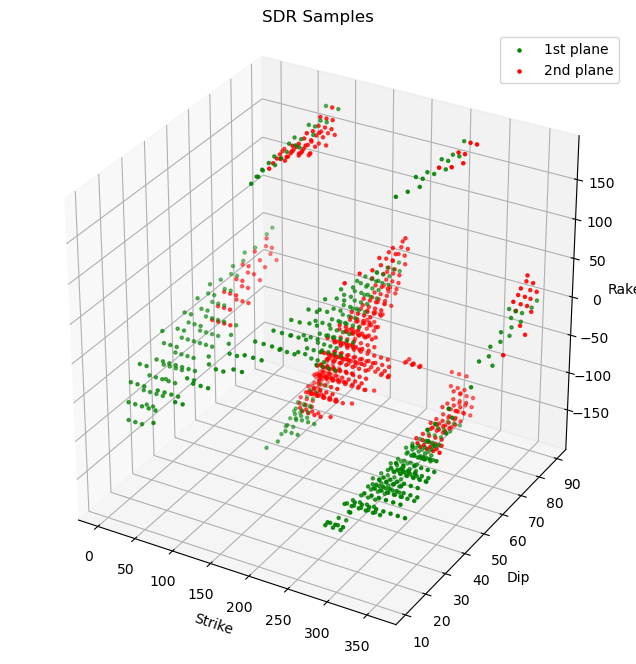

In [606]:
# scatter sdr_pairs[0] in green and sdr_pairs[1] in red

# print(len(sdr_pairs)*2)

fig14 = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')
ax.set_box_aspect((1,1,1))

ax.scatter3D([pair[0][0] for pair in sdr_pairs],
             [pair[0][1] for pair in sdr_pairs],
             [pair[0][2] for pair in sdr_pairs],
             c='g', s=5, label='1st plane')

ax.scatter3D([pair[1][0] for pair in sdr_pairs],
                [pair[1][1] for pair in sdr_pairs],
                [pair[1][2] for pair in sdr_pairs],
                c='r', s=5, label='2nd plane')

ax.set_title("SDR Samples")
ax.set_xlabel('Strike')
ax.set_ylabel('Dip')
ax.set_zlabel('Rake')
ax.legend()
plt.show()

609


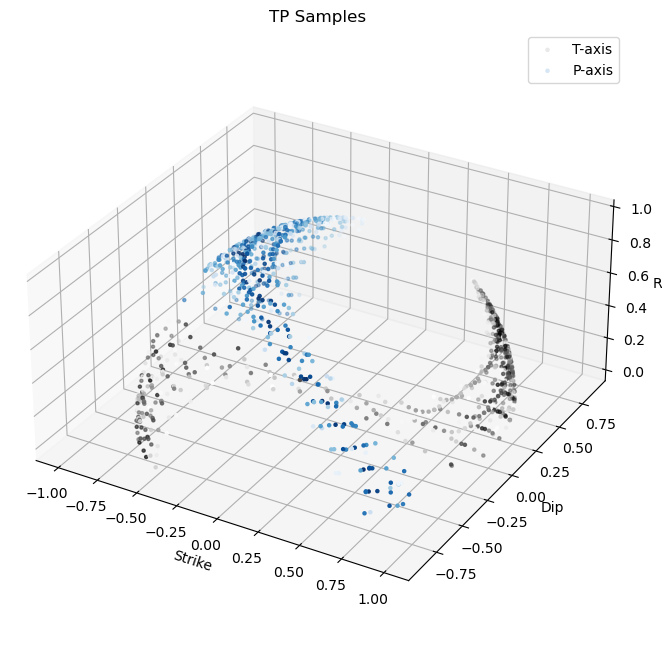

In [646]:
# plot tp[0] in green and tp[1] in red
# include a legend
print(len(tps))
test_tps = tps[:]

fig15 = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')
ax.set_box_aspect((1,1,.5))

ax.scatter3D([tp[0][0] for tp in test_tps],
                [tp[0][1] for tp in test_tps],
                [tp[0][2] for tp in test_tps],
                c=high_cossims, cmap='Greys', s=5, label='T-axis')

ax.scatter3D([tp[1][0] for tp in test_tps],
                [tp[1][1] for tp in test_tps],
                [tp[1][2] for tp in test_tps],
                c=high_cossims, cmap='Blues', s=5, label='P-axis')

ax.set_title("TP Samples")
ax.set_xlabel('Strike')
ax.set_ylabel('Dip')
ax.set_zlabel('Rake')
ax.legend()
plt.show()

In [630]:
tps

[(array([-0.48665637, -0.56163139,  0.66913061]),
  array([ 0.80937857, -0.57810851,  0.10342577])),
 (array([-0.37157241, -0.6435823 ,  0.66913061]),
  array([ 8.66025404e-01, -5.00000000e-01,  1.57009246e-16])),
 (array([-0.37157241, -0.6435823 ,  0.66913061]),
  array([-0.84057771,  0.53920479,  0.05183916])),
 (array([-0.24305886, -0.70227247,  0.66913061]),
  array([-0.81315878,  0.5236126 ,  0.2541705 ])),
 (array([-0.24305886, -0.70227247,  0.66913061]),
  array([-0.87884856,  0.45138933,  0.1545085 ])),
 (array([-0.10576054, -0.73558068,  0.66913061]),
  array([-0.64586758,  0.56245874,  0.51623177])),
 (array([-0.10576054, -0.73558068,  0.66913061]),
  array([-0.74480922,  0.50443695,  0.43680957])),
 (array([-0.10576054, -0.73558068,  0.66913061]),
  array([-0.82925399,  0.43659687,  0.34888536])),
 (array([-0.10576054, -0.73558068,  0.66913061]),
  array([-0.89755828,  0.36025892,  0.2541705 ])),
 (array([ 0.03536025, -0.74230309,  0.66913061]),
  array([-0.64005323,  0.4973

Ao norm: 0.014312381080381756


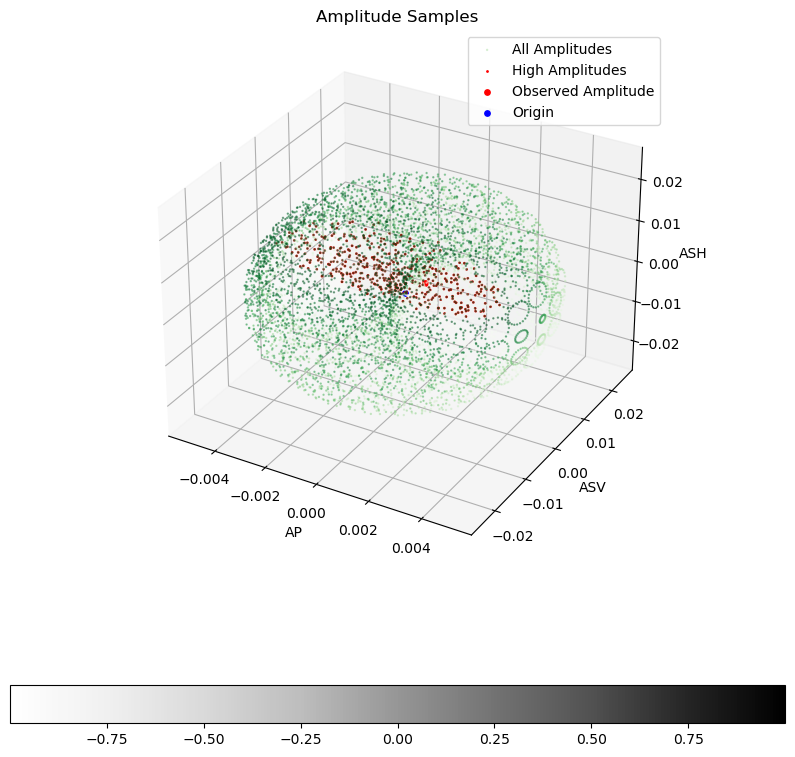

In [608]:
# 3D plot amplitudes

# use amplitudes or unit_amplitudes
cossim_amplitudes = high_amplitudes
Ao_expt = Ao
expt = amplitudes.reshape(-1, 3)
print('Ao norm:', linalg.norm(Ao_expt))

# plot all amplitudes
# viridis, plasma, inferno, magma, cividis
# Greys, Blues, Purples, Greens, Oranges, Reds
# YlOrBr, YlOrRd, OrRd, PuRd, RdPu, BuPu, GnBu, PuBu, YlGnBu, PuBuGn, BuGn, YlGn
fig16 = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
# ax.set_box_aspect((1,1,1))
ax.scatter3D([a[0] for a in expt],
                [a[1] for a in expt],
                [a[2] for a in expt],
                c=cossims, cmap='Greens', s=.5, alpha=0.5, label='All Amplitudes')

ax.scatter3D([a[0] for a in cossim_amplitudes],
                [a[1] for a in cossim_amplitudes],
                [a[2] for a in cossim_amplitudes], c='r', s=1, label='High Amplitudes')

# add Ao to the plot
ax.scatter3D(Ao_expt[0], Ao_expt[1], Ao_expt[2], c='r', s=15, label='Observed Amplitude')
ax.scatter3D(0, 0, 0, c='b', s=15, label='Origin')

ax.set_title("Amplitude Samples")
ax.set_xlabel('AP')
ax.set_ylabel('ASV')
ax.set_zlabel('ASH')
cbar = fig16.colorbar(scatter, ax=ax, orientation='horizontal')

ax.legend()

plt.show()

Ao norm: 0.9999999999999999


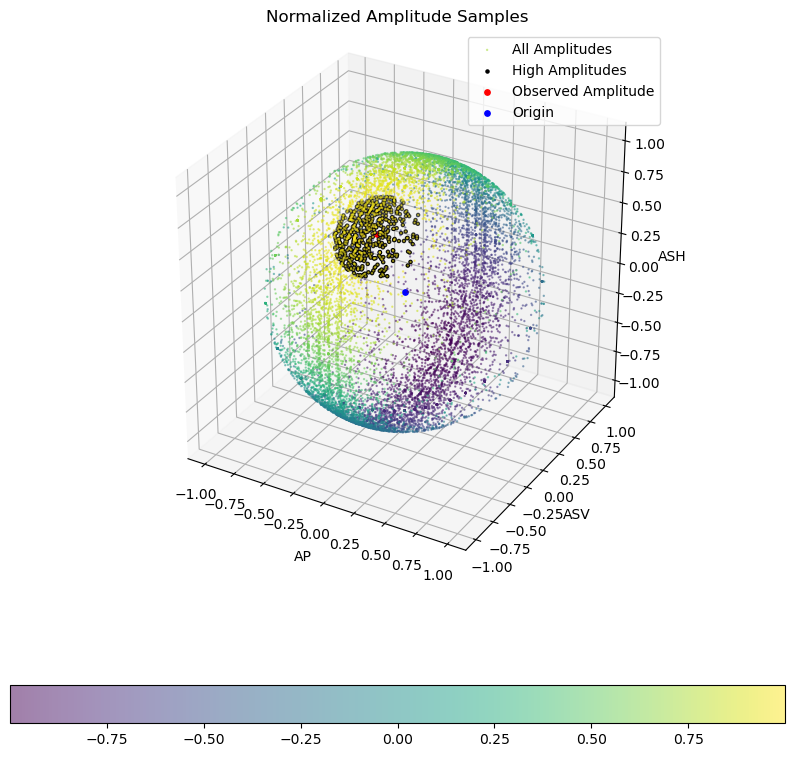

In [664]:
# 3D plot amplitudes

# use amplitudes or unit_amplitudes
cossim_amplitudes = high_unit_amplitudes
Ao_expt = Ao/linalg.norm(Ao)
expt = unit_amplitudes.reshape(-1, 3)
print('Ao norm:', linalg.norm(Ao_expt))

# plot all amplitudes
fig10 = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.set_box_aspect((1,1,1))
scatter = ax.scatter3D([a[0] for a in expt],
                [a[1] for a in expt],
                [a[2] for a in expt],
                c=cossims, cmap='viridis', s=.5, alpha=0.5, label='All Amplitudes')

ax.scatter3D([a[0] for a in cossim_amplitudes],
                [a[1] for a in cossim_amplitudes],
                [a[2] for a in cossim_amplitudes], c='k', s=5, label='High Amplitudes')

# add Ao to the plot
ax.scatter3D(Ao_expt[0], Ao_expt[1], Ao_expt[2], c='r', s=15, label='Observed Amplitude')
ax.scatter3D(0, 0, 0, c='b', s=15, label='Origin')

ax.set_title("Normalized Amplitude Samples")
ax.set_xlabel('AP')
ax.set_ylabel('ASV')
ax.set_zlabel('ASH')
cbar = fig10.colorbar(scatter, ax=ax, orientation='horizontal')

ax.legend()

plt.show()

**Inversion**

In [610]:
# initialize seismic model

phi = deg2rad(azimuth)
i, j = deg2rad(takeoff_angles)
d = Ao
inverse_model = sm.SeismicModel(phi, i, j, alpha, beta, d)
options = mo.init_options()
options['output_level'] = 0
options['tol'] = 1e-5

0 local minima out of 0 failures
Number of solutions: 7544


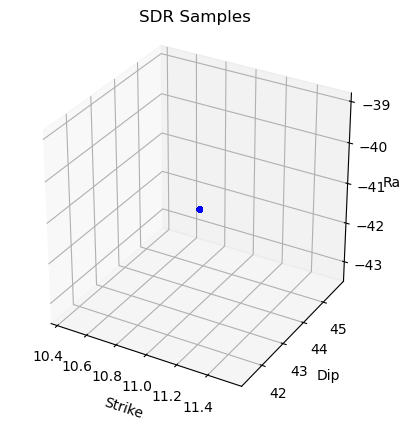

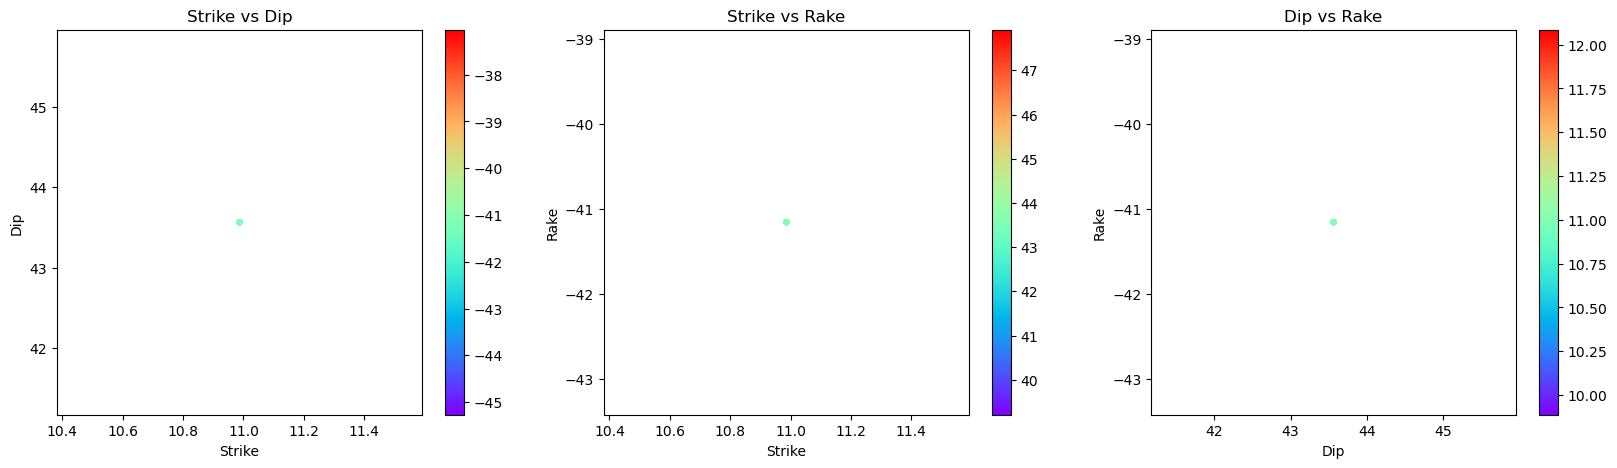

In [611]:
# 1st plane
importlib.reload(mo)
importlib.reload(fx)

solutions = []
num_failures = 0
local_minima = 0
for sdr in sdrs:
    inverse_model.reset()
    inverse_model.set_initial_guess(sdr)
    status, m_sol, E_sol = mo.minimize(inverse_model, options)
    if status == 'success' and abs(E_sol + 1) < options['tol']:
        m_sol = fx.bound_sdr(m_sol, dont=True)
        solutions.append(rad2deg(m_sol))
    else:
        num_failures += 1
        if abs(E_sol + 1) < eps: local_minima += 1
solutions = array(solutions)
print(f'{local_minima} local minima out of {num_failures} failures')
print(f'Number of solutions: {len(solutions)}')
# plot solutions
fig5 = plt.figure()
ax = plt.axes(projection='3d')
ax.set_box_aspect((1,1,1))
ax.scatter3D(solutions[:,0], solutions[:,1], solutions[:,2], c='b', s=10)
ax.set_title("SDR Samples")
ax.set_xlabel('Strike')
ax.set_ylabel('Dip')
ax.set_zlabel('Rake')
plt.show()

# 2D scatterplots for sd/sr/dr
fig6 = plt.figure(figsize=(20,5))
ax1 = fig6.add_subplot(131)
plt1 = ax1.scatter(solutions[:,0], solutions[:,1],
                   c=solutions[:,2], s=10, cmap='rainbow')
ax1.set_title("Strike vs Dip")
ax1.set_xlabel('Strike')
ax1.set_ylabel('Dip')
cbar1 = fig6.colorbar(plt1)
ax2 = fig6.add_subplot(132)
plt2 = ax2.scatter(solutions[:,0], solutions[:,2],
                     c=solutions[:,1], s=10, cmap='rainbow')
ax2.set_title("Strike vs Rake")
ax2.set_xlabel('Strike')
ax2.set_ylabel('Rake')
cbar2 = fig6.colorbar(plt2)
ax3 = fig6.add_subplot(133)
plt3 = ax3.scatter(solutions[:,1], solutions[:,2],
                        c=solutions[:,0], s=10, cmap='rainbow')
ax3.set_title("Dip vs Rake")
ax3.set_xlabel('Dip')
ax3.set_ylabel('Rake')
cbar3 = fig6.colorbar(plt3)
plt.show()

In [612]:
importlib.reload(fx)
# 2nd plane

solutions_alt = []
num_failures = 0
local_minima = 0
for sdr in sdrs_alt:
    inverse_model.reset()
    inverse_model.set_initial_guess(sdr)
    status, m_sol, E_sol = mo.minimize(inverse_model, options)
    if status == 'success' and abs(E_sol + 1) < options['tol']:
        m_sol = fx.bound_sdr(m_sol)
        solutions_alt.append(rad2deg(m_sol))
    else:
        num_failures += 1
        if abs(E_sol + 1) < eps: local_minima += 1
solutions_alt = array(solutions_alt)
print(f'{local_minima} local minima out of {num_failures} failures')
print(f'Number of solutions: {len(solutions_alt)}')

0 local minima out of 0 failures
Number of solutions: 7544


Original sdr: [ 141.05743276   64.77466961 -112.7692599 ]


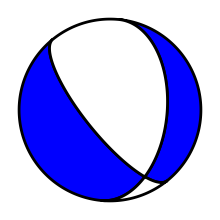

Solution 1: [ 10.98643219  43.5638409  -41.15476657]


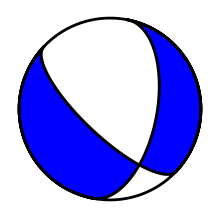

Solution 2: [ 10.98643219  43.5638409  -41.15476657]


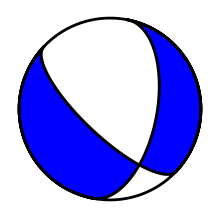

In [613]:
importlib.reload(fx)
# plot beachball of orig and 2 random solutions

print(f'Original sdr: {sdr_orig}')
orig = fx.beachball(sdr_orig)

index1 = random.randint(0, len(solutions))
print(f'Solution 1: {solutions[index1]}')
inv1 = fx.beachball(solutions[index1])
index2 = random.randint(0, len(solutions_alt))
print(f'Solution 2: {solutions_alt[index2]}')
inv2 = fx.beachball(solutions_alt[index2])

[640.04380856 539.20501895 548.10606287]


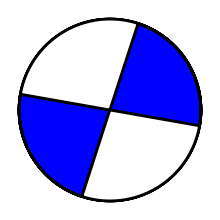

[ 100.04380856    0.79498105 -171.89393713]


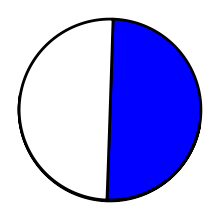

In [614]:
s = random.randint(0, 1000)
d = random.randint(0, 1000)
r = random.randint(0, 1000)

rand_mech = array([s,d,r]).astype(float)
rand_mech += random.rand(3)
print(rand_mech)
fx.beachball([s,d,r]);

bounded = fx.bound_sdr(rand_mech, deg=True)
print(bounded)
fx.beachball(bounded);

# TODO:
# the real test: what's the cosine similarity?

In [615]:
inverted = solutions_alt[index1]

# forward model using rpattern
Ainv = fx.Rpattern(inverted, azimuth, takeoff_angles, [alpha, beta])
similarity = fx.cossim(Ao, Ainv)
other_similarity = -inverse_model.value(deg2rad(inverted))
print(similarity, other_similarity)

# compare Esol with Rpattern!!!
# it matches but it's not 1 >> why?

# seeds that work
# 123 NICE! exact recovery
# 1234 HORRIBLE! BUG fixed

0.999999999902386 0.999999999902386


In [616]:
'''
THINK more deeply about the trigonometric periodicity
Investigate solution stability after (see if it was an artifact of the BUG)
Consider flagging every point at which we have to bound the solution
'''

'\nTHINK more deeply about the trigonometric periodicity\nInvestigate solution stability after (see if it was an artifact of the BUG)\nConsider flagging every point at which we have to bound the solution\n'

Running gradient_descent method with backtracking line search at step size 1


# Iterations v func evals........: 69 v 94
Final objective..................: -0.999999999902386
||grad|| at final point..........: 6.327512320087876e-06
Status: Critical point found.
Original sdr: [ 141.05743276   64.77466961 -112.7692599 ] vs
soln: [ 10.98643219  43.5638409  -41.15476657]
Cossim: 0.999999999902386


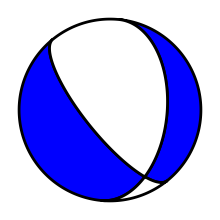

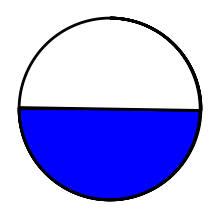

In [617]:
# do a quick one using initial guess close to the solution
# and see if it converges to the same solution

options['output_level'] = 1
inverse_model.reset()
inverse_model.set_initial_guess(deg2rad(sdr_orig))
status, m_sol, E_sol = mo.minimize(inverse_model, options)

# m_sol = fx.bound_sdr(m_sol) # THIS IS THE BUG!!!

# 1. Why? Source function
# 2. Can we pass through tp instead?

print(f'Original sdr: {sdr_orig} vs\nsoln: {rad2deg(m_sol)}')
print(f"Cossim: {-inverse_model.value(m_sol)}")

orig = fx.beachball(sdr_orig)
inv = fx.beachball(m_sol)

More observations:

* We may have a case of stable vs unstable equilibria!
* Comare with gradient descent from known starting points
* Sometimes the cossim is negative - why??

* Priority is to make sure gradient descent is doing what I think it's doing

***
B. Gradient descent from sdr space - not necessary
***

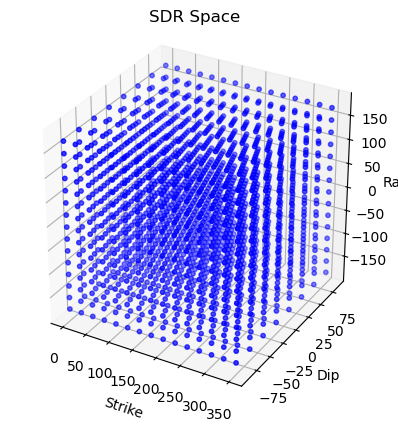

In [618]:
sdr_space = []
step_size = 25

for s in range(0, 360, step_size):
    for d in range(-90, 91, step_size):
        for r in range(-180, 181, step_size):
            sdr_space.append([s, d, r])
sdr_space = array(sdr_space)

# plot solutions
fig9 = plt.figure()
ax = plt.axes(projection='3d')
ax.set_box_aspect((1,1,1))
ax.scatter3D(sdr_space[:,0], sdr_space[:,1], sdr_space[:,2], c='b', s=10)
ax.set_title("SDR Space")
ax.set_xlabel('Strike')
ax.set_ylabel('Dip')
ax.set_zlabel('Rake')
plt.show()

***
Produce visuals in SDR space
***